In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *

In [2]:
import tensorly as tl
import numpy as np
import torch
import math
import time
import random
import matplotlib.pyplot as plt
from skimage import data

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk

In [3]:
x = np.array([1.0, 2.0, 3.0, 4.0])
G = np.diag(1.0/x)
G_inv = np.diag(x)
print(G_inv)
dF = np.array([1.0, 2.0, 3.0, 4.0])
print(np.sum(dF * G_inv@dF))
print(np.sum(dF * x * dF))

A = np.random.rand(2,3)
dF = np.random.rand(2, 3)
print(tl.sum(dF * A * dF))
#print(
step_size_modifiers = []
for i in range(3):
    step_size_modifiers.append([])
print(step_size_modifiers)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]]
100.0
100.0
1.4358630983039529
[[], [], []]


In [4]:
tensor = tl.random.random_tensor((10, 10))
tl.context(tensor)
tl.set_backend('pytorch')
print(tl.get_backend())
torch.cuda.is_available()

pytorch


True

In [5]:
def is_tensor_not_finite(tensor):
    """
    Checks if the tensor contains some non-finite elements, i.e. not inf or nan
    Returns true if it finds any non-finite elements and returns false if all elements are finite
    can use both numpy and pytorch tensor

    Is using in the tensor_factorization_cp_poisson function inside the step size calculation to make sure the gradient is finite
    """
    if tl.get_backend() == 'pytorch':
        return torch.any(~torch.isfinite(tensor))
    if tl.get_backend() == 'numpy':
        return np.any(~np.isfinite(tensor))
    else: # default to using numpy by first casting the array to numpy
        return np.any(~np.isfinite(np.array(tensor)))

In [6]:
def tensor_factorization_cp_poisson(X, F, error=1e-6, max_iter=500, detailed=False, verbose=False):
    """
    This function uses a multiplicative method to calculate a nonnegative tensor decomposition
    
    Args:
      X: The tensor of dimension N we want to decompose. X \in \RR^{I_1 x ... x I_N}
      F: The order of the apporximation
      error: stops iteration if difference between X and approximation with decomposition changes less then this
      max_iter: maximum number of iterations
      detailed: if false, function returns only G and the As. if true returns also all errors found during calculation 
      verbose: If True, prints additional information
    
    Returns:
      A list of tensors approximating X 
    """
    
    N = X.ndim # get dimension of X
    X_shape = X.shape
    norm_X = tl.norm(X)
    # initialize A_j with random positive values
    A_ns = []
    for i in range(N):
        # we use random.random_tensor as it returns a tensor
        A_ns.append(tl.random.random_tensor((X_shape[i], F), **tl.context(X)))
    
    # the reconstruction error
    approximated_X = defactorizing_CP(A_ns, X_shape)
        
    RE = [tl.norm(X-approximated_X)/norm_X]

    # lets save the different m as well so that we can run some analysis there
    step_size_modifiers = []
    for i in range(N):
        step_size_modifiers.append([])
    for _ in range(max_iter):
        for n in range(N):
            start = time.time()
            
            khatri_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
            approximated_X_unfolded_n = tl.matmul(A_ns[n], tl.transpose(khatri_rao_product)) # TODO consider if we want to use the same for all matrizes or update along the way
            
            ###### Step size calculation ######
            # TODO these values should be looked at more to determine which are best
            sigma = 0.5
            beta = 0.5
            alpha = 0.5
            m = 0 # TODO need to find some estimation for first m! otherwise need to compute too much
            # for now, just use 0.7 of what was used last time
            if len(step_size_modifiers[n]) > 0:
                m = int(step_size_modifiers[n][-1] * 0.7)
            step_size = math.pow(beta, m) * alpha
            f = lambda A: tl.sum( tl.matmul(A, tl.transpose(khatri_rao_product)) - tl.base.unfold(X, n) * tl.log( tl.matmul(A, tl.transpose(khatri_rao_product)) )) 
            function_value_at_iteration = tl.sum(approximated_X_unfolded_n - tl.base.unfold(X, n) * tl.log(approximated_X_unfolded_n)) 
            gradient_at_iteration = tl.matmul(tl.ones(approximated_X_unfolded_n.shape, **tl.context(X)) - (tl.base.unfold(X, n) / approximated_X_unfolded_n) , khatri_rao_product )
            riemanndian_gradient_at_iteration = A_ns[n] * gradient_at_iteration # The "A_ns[n] *" is the inverse of the Riemannien metric tensor matrix thing
            norm_of_rg = tl.sum(gradient_at_iteration * riemanndian_gradient_at_iteration) # TODO maybe check if this is correct!
            next_iterate =  A_ns[n] * tl.exp(-step_size * riemanndian_gradient_at_iteration)
            # TODO get rid of just using numpy for checking for infinity, to also make use of pytorch as well.
            while is_tensor_not_finite(next_iterate) or ( function_value_at_iteration - sigma * step_size * norm_of_rg < f(next_iterate) ):
                m += 1
                step_size = math.pow(beta, m) * alpha
                next_iterate =  A_ns[n] * tl.exp(-step_size * gradient_at_iteration)
            
            step_size_modifiers[n].append(m) # save the value of m for later inspection
            ###### update A_ns[n]
            A_ns[n] = next_iterate
            # OLD CODE, kept for safety
            # regular * does componentwise multiplication
            #A_ns[n] = A_ns[n] * tl.exp(-step_size * tl.matmul(tl.ones(approximated_X_unfolded_n.shape) - (tl.base.unfold(X, n) / approximated_X_unfolded_n) , khatri_rao_product )  ) 
            
            end = time.time()
            if verbose:
                print("Current index: " + str(n))
                print("Calculculation time: " + str(end - start))
                print("New objective function value: " + str(f(A_ns[n])))
                print("step size was: " + str(step_size) + " with m = " + str(m))

                print("function_value_at_iteration = " + str(function_value_at_iteration))
                print("norm_of_rg = " + str(norm_of_rg))
                print("gradiend_at_iteration = ")
                print(gradient_at_iteration)
                print("riemannian_gradient_at_iteration = ")
                print(riemanndian_gradient_at_iteration)

                print("new A_ns[n]:")
                print(A_ns[n])
                
                
            
        # the reconstruction error
        approximated_X = defactorizing_CP(A_ns, X_shape)
        RE.append(tl.norm(X-approximated_X)/norm_X)

        if verbose:
            print("current apporximation error is: " + str(RE[-1]))
            #print("approximation is:")
            #print(approximated_X)
        
        # check if we have converged
        if abs(RE[-1] - RE[-2]) < error:
            break

    # TODO I think we can skip this for now
    """
    # Rescale the A_ns
    # TODO there should be a smarter way of calculating K
    K = []
    for n in range(N):
        K_j = []
        for a in range(F):
            sum = 0
            for i in range(X_shape[n]):
                sum += A_ns[n][i, a]**2
            K_j.append(math.sqrt(sum))
        K.append(K_j)
    K = tl.tensor(K, **tl.context(X))
    for n in range(N):
        for a in range(F):
            A_ns[n][:, a] = A_ns[n][:, a] * math.pow(tl.prod(K[:, a]), 1.0/N) / K[n, a]
    """

    if detailed:
        return A_ns, RE, approximated_X, step_size_modifiers
    return A_ns

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(


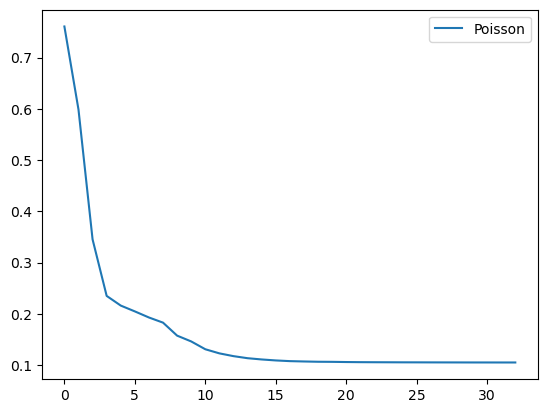

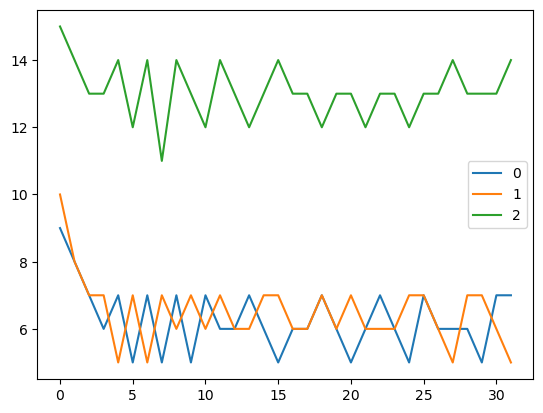

In [123]:
# Testing just poisson algo
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise

start = time.time()
A_ns, RE_poisson, approx_poisson, step_size_modifiers = tensor_factorization_cp_poisson(X, F, max_iter=100, detailed=True, verbose=False)
end = time.time()
plt.plot(RE_poisson, label="Poisson")
plt.legend()
plt.show()

for n, modifiers in enumerate(step_size_modifiers):
    plt.plot(modifiers, label=n)
plt.legend()
plt.show()

Current index: 0
Calculculation time: 0.0
New objective function value: 168.05275839683551
step size was: 0.0625 with m = 3
function_value_at_iteration = 195.38841809323526
norm_of_rg = 646.3136266123772
gradiend_at_iteration = 
[[  4.56309401   5.35385023]
 [  8.98496494   6.51990231]
 [-20.81646811  -2.51868923]
 [  8.32340333   6.11810269]
 [-20.11569071  -2.2711415 ]
 [ 10.08279616   7.17074249]
 [  5.72648936   3.82062699]
 [  8.49708845   6.13702322]
 [ -0.49958061   4.27757219]
 [-37.429575    -6.94786786]]
riemannian_gradient_at_iteration = 
[[ 1.61901924  5.17271498]
 [ 5.82614296  5.86337437]
 [-1.98809425 -1.02340402]
 [ 7.42767234  5.92386934]
 [-1.44999646 -0.60879723]
 [ 5.80787775  5.80943137]
 [ 4.48052287  2.00641185]
 [ 6.12442262  5.54193165]
 [-0.08813379  4.12011758]
 [-2.49112009 -2.52952023]]
new A_ns[n]:
[[0.26676858 0.69140196]
 [0.36981303 0.59832092]
 [0.35080013 0.47559615]
 [0.53042781 0.66057566]
 [0.25341968 0.3089406 ]
 [0.30672915 0.51752476]
 [0.547020

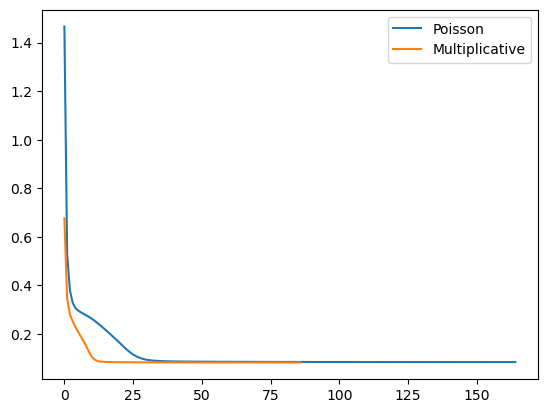

In [17]:
# Comparing on CPU
tl.set_backend('numpy')
dimensions = (10, 10, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=True)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.legend()
plt.show()

Poisson algorithm took 0.9689993858337402 seconds with 105 iterations and had final error of tensor(21.0073, device='cuda:0')
Multiplicative algorithm took 0.2710001468658447 seconds with 300 iterations and had final error of tensor(20.6620, device='cuda:0')
Muliplicative algorithm was 3.5756415523768386 times faster in total
Muliplicative algorithm was 10.279969463083411 times faster per iteration


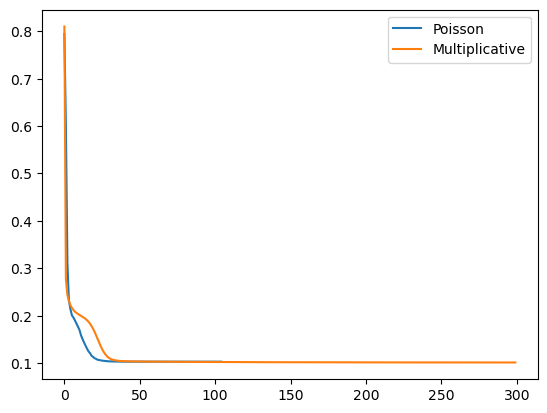

In [13]:
# Comparing on GPU with pytorch
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")

plt.plot([value.cpu() for value in RE_poisson], label="Poisson")
plt.plot([value.cpu() for value in RE_mult], label="Multiplicative")
plt.legend()
plt.show()

In [32]:
tl.exp(666*1)

1.7383008701505047e+289